# KEN3450, Data Analysis, Spring 2020

### Clinic 2: Regression in Python

***
### Learning Goals:

By the end of this clinic, you should be able to:

* Run simple Regression Models with single & multiple variables
* Run Polynomial Regression Models
* Do model selection using:
    * Train-Test splits
    * Cross Validation
* Judge the results of model fitting
* Explain reguralization and apply it on your models 

***

In [1]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline
import numpy as np
import pandas as pd
pd.set_option('display.width', 700)
pd.set_option('display.max_columns', 300)
pd.set_option('display.notebook_repr_html', True)

import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.tools import add_constant
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

# special matplotlib argument for improved plots
from matplotlib import rcParams

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
plt.style.use('seaborn-white')
sns.set(style="ticks")

***
# Part 0: Linear Regression (refresher)
### Purpose of linear regression
***
<div class="span5 alert alert-info">

<p> Given a dataset $X$ and $Y$, linear regression can be used to: </p>
<ul>
  <li> Build a <b>predictive model</b> to predict future values of $X_i$ without a $Y$ value.  </li>
  <li> Model the <b>strength of the relationship</b> between each dependent variable $X_i$ and $Y$</li>
    <ul>
      <li> Sometimes not all $X_i$ will have a relationship with $Y$</li>
      <li> Need to figure out which $X_i$ contributes most information to determine $Y$ </li>
    </ul>
   <li>Linear regression is used in so many applications that I won't warrant this with examples. It is in many cases, the first pass prediction algorithm for continuous outcomes. </li>
</ul>
</div>

### A brief recap
***

Linear Regression is a method to model the relationship between a set of independent variables $X$ (also knowns as explanatory variables, features, predictors) and a dependent variable $Y$.  This method assumes the relationship between each predictor $X$ is linearly related to the dependent variable $Y$.  

$$ Y = \beta_0 + \beta_1 X + \epsilon$$

where $\epsilon$ is considered as an unobservable random variable that adds noise to the linear relationship. This is the simplest form of linear regression (one variable), we'll call this the simple model. 

* $\beta_0$ is the intercept of the linear model

* Multiple linear regression is when you have more than one independent variable
    * $X_1$, $X_2$, $X_3$, $\ldots$

$$ Y = \beta_0 + \beta_1 X_1 + \ldots + \beta_p X_p + \epsilon$$ 

* Back to the simple model. The model in linear regression is the *conditional mean* of $Y$ given the values in $X$ is expressed a linear function.  

$$ y = f(x) = E(Y | X = x)$$ 

![conditional mean](images/conditionalmean.png)

* The goal is to estimate the coefficients (e.g. $\beta_0$ and $\beta_1$). We represent the estimates of the coefficients with a "hat" on top of the letter.  

$$ \hat{\beta}_0, \hat{\beta}_1 $$

* Once you estimate the coefficients $\hat{\beta}_0$ and $\hat{\beta}_1$, you can use these to predict new values of $Y$

$$\hat{y} = \hat{\beta}_0 + \hat{\beta}_1 x_1$$


* How do you estimate the coefficients? 
    * There are many ways to fit a linear regression model
    * The method called **least squares** is one of the most common methods
    
### Estimating $\hat\beta$: Least squares
***
Least Squares is a method that can estimate the coefficients of a linear model by minimizing the difference between the following: 

$$ S = \sum_{i=1}^N r_i = \sum_{i=1}^N (y_i - (\beta_0 + \beta_1 x_i))^2 $$

where $N$ is the number of observations.  

* We will not go into the mathematical details, but the least squares estimates $\hat{\beta}_0$ and $\hat{\beta}_1$ minimize the sum of the squared residuals $r_i = y_i - (\beta_0 + \beta_1 x_i)$ in the model (i.e. makes the difference between the observed $y_i$ and linear model $\beta_0 + \beta_1 x_i$ as small as possible). 

The solution can be written in compact matrix notation as

$$\hat\beta =  (X^T X)^{-1}X^T Y$$ 

In case you remember linear algebra, in order for this solution to exist we need $X^T X$ to be invertible. Of course this requires a few extra assumptions, $X$ must be full rank so that $X^T X$ is invertible, etc. **This is important for us because this means that having redundant features in our regression models will lead to poorly fitting (and unstable) models.** We'll see an implementation of this in the extra linear regression example.

**Note**: The "hat" means it is an estimate of the coefficient.  

# Part 1a: Simple linear regression
We will now use sklearn to to predict automobile milesage per gallon (mpg) and evaluate these predictions. We first load the data and split them into a training set and a testing set. After we import the data, we should check that all values are imported as they were supposed to be. Is that the case?

In [2]:
#load mtcars
dfcars=pd.read_csv("data/mtcars.csv")
dfcars=dfcars.rename(columns={"Unnamed: 0":"name"})
dfcars.head()
#additional code for checks here

,name,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [5]:
#split into training set and testing set
from sklearn.model_selection import train_test_split
#set random_state to get the same split every time
traindf, testdf = train_test_split(dfcars, test_size=0.3, random_state=6)

In [6]:
#testing set is ~30% of the total data; training set is ~70%
dfcars.shape, traindf.shape, testdf.shape

((32, 12), (22, 12), (10, 12))

We need to choose the variables that we think will be good predictors for the dependent variable `mpg`. 

>**DISCUSS:**  Pick one variable to use as a predictor for simple linear regression.  Create a markdown cell below and discuss your reasons.  You may want to justify this with some visualizations.  Is there a second variable you'd like to use as well, say for multiple linear regression with two predictors?

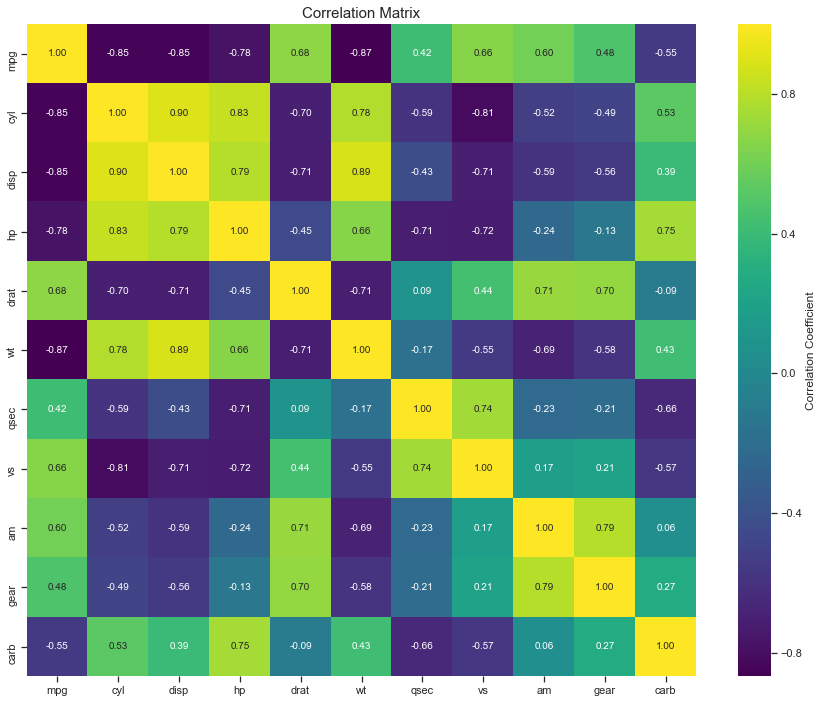

In [20]:
f, ax = plt.subplots(figsize= [15,12])
sns.heatmap(dfcars.corr(), annot=True, fmt=".2f", ax=ax, 
            cbar_kws={'label': 'Correlation Coefficient'}, cmap='viridis')
ax.set_title("Correlation Matrix", fontsize=15)
plt.show()

As we can see on the correlation matrix above, `wt` has the strongest correlation with `mpg`, so that's the variables we should use for regression. A second variable worth using is `cyl`.

> **PRACTICE:** Revisit the code of Lecture notebook and (with either sklearn or statsmodels) fit the training data using simple linear regression.
> 1. Use the model to make mpg predictions on testing set.  
> 2. Plot the data and the prediction.  
> 3. Print out the R squared for the training set.
> 4. Print out the mean squared error for the training set and the testing set and compare.

In [45]:
# Apparently by using double instead of single brackets in X we can
# avoid reshaping it later on 
# Reference: https://stackoverflow.com/questions/47761744/cant-do-linear-regression-in-scikit-learn-due-to-reshaping-issue
X = dfcars[['wt']]
y = dfcars.mpg

In [51]:
predictor = 'wt'
x_train, y_train = traindf[[predictor]], traindf.mpg
x_test, y_test = testdf[[predictor]], testdf.mpg

Regression intercept 37.77785841313509
Coefficient of predictor -5.252574103908987


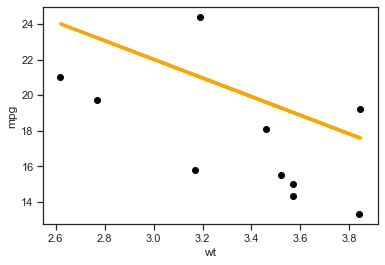

In [52]:
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score

regr = skl_lm.LinearRegression()
regr.fit(x_train,y_train)

y_preds = regr.predict(x_test.values.reshape(-1,1))

plt.scatter(x_test, y_test,  color='black')
plt.plot(x_test, y_preds,color='orange', linewidth=3)

plt.xlabel('wt')
plt.ylabel('mpg')

print("Regression intercept",regr.intercept_)
print("Coefficient of predictor",regr.coef_[0])


In [53]:
#You are given this part to compute MSE for training set, as well as the R_squared
#Pay attention to the variables declared here (e.g. y_train, y_test etc.), as they need to match yours

train_MSE2 = np.mean((y_train - regr.predict(x_train))**2)
test_MSE2 = np.mean((y_test - regr.predict(x_test))**2)
print("The training MSE is %2f, the testing MSE is %2f" %(train_MSE2, test_MSE2))

## or with sklearn.metrics
# from sklearn.metrics import mean_squared_error
# print(mean_squared_error(y_train, regr.predict(x_train)))
# print(mean_squared_error(y_test, regr.predict(x_test)))

#Compute R_squared
print('The train R^2 is {}'.format(regr.score(x_train, y_train)))
print('The test R^2 is {}'.format(regr.score(x_test, y_test)))

The training MSE is 7.308504, the testing MSE is 13.767534
The train R^2 is 0.8269577421574656
The test R^2 is -0.26538669935441983


Training MSE is lower than testing MSE as expected. The difference is so large that I would say we are overfitting. However, the dataset so small that the performance heavily depends on the train-test split. With a different split I achieved training MSE of 8.9 and testing MSE of 8.3.

### Basic Residual Analysis

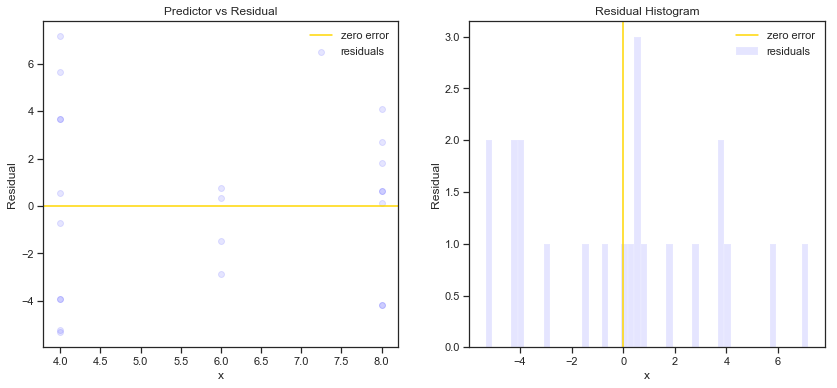

In [15]:
#This part is also given

fig, ax = plt.subplots(1, 2, figsize=(14,6))

errors = y_train - reg.predict(x_train)
ax[0].scatter(x_train, errors, color='blue', alpha=0.1, label='residuals')
ax[0].axhline(y=0, color='gold', label='zero error')

ax[0].set_xlabel('x')
ax[0].set_ylabel('Residual')
ax[0].set_title('Predictor vs Residual')
ax[0].legend(loc='best')

ax[1].hist(errors, color='blue', alpha=0.1, label='residuals', bins=50, edgecolor='white', linewidth=2)
ax[1].axvline(x=0, color='gold', label='zero error')


ax[1].set_xlabel('x')
ax[1].set_ylabel('Residual')
ax[1].set_title('Residual Histogram')
ax[1].legend(loc='best')

What do you observe about the residuals? Is the fit good?

# Part 1b: Multiple linear regression

> **EXERCISE:** With either sklearn or statsmodels, fit the training data using multiple linear regression with two predictors.
> 1. Use the model to make mpg predictions on testing set.
> 2. Print out the mean squared error for the training set and the testing set and compare.  
> 3. How do these training and testing mean squared errors compare to those from the simple linear regression?
> 4. (AT HOME FOR PRACTICE) Time permitting, repeat the training and testing with three predictors and calculate the mean squared errors.  How do these compare to the errors from the one and two predictor models?

In [ ]:
#your code here
x_train2 = 
x_test2 = 

#create linear regression, train and make predictions


#print coefficients


#print MSE (training/testing) and comment on the results
#this part is given
train_MSE2= np.mean((y_train - regr.predict(x_train2))**2)
test_MSE2= np.mean((y_test - regr.predict(x_test2))**2)
print("The training MSE is %2f, the testing MSE is %2f" %(train_MSE2, test_MSE2))


What do you observe now for the training and testing MSE? Discuss!

## Evaluating the Significance of Predictors

In [18]:
#this part is given, and you should be able to judge/comment on the outcomes
predictors_multiple = ['wt', 'hp','disp','drat']
predictors_simple = ['wt']

X_train_multi = add_constant(traindf[predictors_multiple].values)
X_test_multi = add_constant(testdf[predictors_multiple].values)

X_train_simple = add_constant(traindf[predictors_simple].values)
X_test_simple = add_constant(testdf[predictors_simple].values)

### 1. Measuring Significance Using F-Statistic, p-Values

In [19]:
multi_regression_model = sm.OLS(y_train, X_train_multi).fit()
print('F-stat:', multi_regression_model.fvalue)
print('p-values: {} (intercept), {} (wt), {} (hp), {} (disp), {} (drat)'.format(*multi_regression_model.pvalues))

F-stat: 23.7079948180275
p-values: 0.0188216885154358 (intercept), 0.014851174334183304 (wt), 0.5614157415604287 (hp), 0.5634300967814695 (disp), 0.3101461538416925 (drat)


### 2. Measuring Significance Using AIC/BIC

In [20]:
print("AIC for 4-predictors-model:", multi_regression_model.aic)
print("BIC for 4-predictors-model:", multi_regression_model.bic)

AIC for 4-predictors-model: 113.34172018056819
BIC for 4-predictors-model: 118.79693244735977


In [21]:
simple_regression_model = sm.OLS(y_train, X_train_simple).fit()
print("AIC for ['wt']:", simple_regression_model.aic)
print("BIC for ['wt']:", simple_regression_model.bic)

AIC for ['wt']: 110.19214504219715
BIC for ['wt']: 112.37422994891378


### 3. Measuring Significance Using R^2

In [22]:
simple_model = LinearRegression(fit_intercept=False)
simple_model.fit(X_train_simple, y_train)

print("Simple Model: train R^2 = {}".format(simple_model.score(X_train_simple, y_train)))

multiple_model = LinearRegression(fit_intercept=False)
multiple_model.fit(X_train_multi, y_train)


print("Multiple Predictor Model: train R^2 = {}".format(multiple_model.score(X_train_multi, y_train)))





Simple Model: train R^2 = 0.8269577421574659
Multiple Predictor Model: train R^2 = 0.8479862369364353


### 4. The Effect of Number of Predictors on R^2

In [23]:
multi_regression_model = LinearRegression(fit_intercept=True)

cols = ['cyl','disp','hp','drat','wt','qsec','vs','am','gear','carb']
train_R_sq = []
test_R_sq = []
for i in range(1, len(cols) + 1):
    predictors = cols[:i]
    X_train = traindf[predictors].values
    X_test = testdf[predictors].values
    
    multi_regression_model.fit(X_train, y_train)
    
    train_R_sq.append(multi_regression_model.score(X_train, y_train))
    test_R_sq.append(multi_regression_model.score(X_test, y_test))

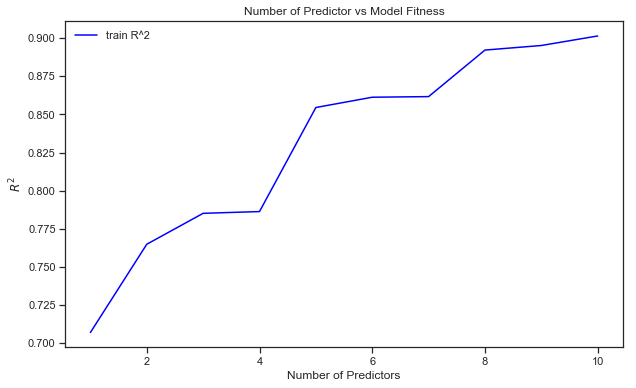

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(range(1, len(cols) + 1), train_R_sq, color='blue', label='train R^2')
#ax.plot(range(1, len(cols) + 1), test_R_sq, color='red', label='test R^2')

ax.set_title('Number of Predictor vs Model Fitness')
ax.set_xlabel('Number of Predictors')
ax.set_ylabel('$R^2$')
ax.legend(loc='best')

plt.show()


## Important things to think about when fitting a linear regression model
***
<div class="span5 alert alert-danger">
<ul>
  <li>**Linearity**. The dependent variable $Y$ is a linear combination of the regression coefficients and the independent variables $X$. </li>
  <li>**Constant standard deviation**. The SD of the dependent variable $Y$ should be constant for different values of X.  
    </li>
  <li> **Normal distribution for errors**.  The $\epsilon$ term we discussed at the beginning are assumed to be normally distributed. 
  $$ \epsilon_i \sim N(0, \sigma^2)$$
Sometimes the distributions of responses $Y$ may not be normally distributed at any given value of $X$.  e.g. skewed positively or negatively. </li>
<li> **Independent errors**.  The observations are assumed to be obtained independently.
    <ul>
        <li>e.g. Observations across time may be correlated
    </ul>
</li>
</ul>  

</div>


# Part 2: Fitting polynomial models

### 2a. Reading in and sampling from another dataset

In [25]:
df=pd.read_csv("data/noisypopulation.csv")
df.head()

,f,x,y
0,0.047790,0.00,0.011307
1,0.051199,0.01,0.010000
2,0.054799,0.02,0.007237
3,0.058596,0.03,0.000056
4,0.062597,0.04,0.010000


In [26]:
x=df.f.values
f=df.x.values
y=df.y.values

In [27]:
df.shape

(200, 3)

From 200 points on this curve, we'll make a random choice of 60 points. We do it by choosing the indexes randomly, and then using these indexes as a way of grtting the appropriate samples

In [28]:
indexes=np.sort(np.random.choice(x.shape[0], size=60, replace=False))
indexes

array([  2,   6,  12,  21,  22,  23,  29,  31,  34,  36,  40,  42,  43,
        45,  47,  49,  51,  68,  71,  75,  78,  79,  82,  87,  89,  93,
        95,  96,  97,  98, 103, 104, 105, 108, 114, 117, 119, 120, 123,
       125, 129, 132, 133, 134, 142, 145, 153, 155, 161, 166, 167, 169,
       171, 174, 179, 188, 189, 190, 195, 196])

In [29]:
samplex = x[indexes]
samplef = f[indexes]
sampley = y[indexes]

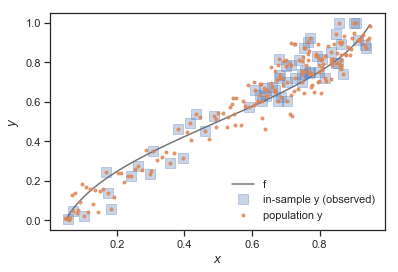

In [30]:
plt.plot(x,f, 'k-', alpha=0.6, label="f");
plt.plot(x[indexes], y[indexes], 's', alpha=0.3, ms=10, label="in-sample y (observed)");
plt.plot(x, y, '.', alpha=0.8, label="population y");
plt.xlabel('$x$');
plt.ylabel('$y$')
plt.legend(loc=4);

In [31]:
sample_df=pd.DataFrame(dict(x=x[indexes],f=f[indexes],y=y[indexes]))

### 2b. Fit on training set and predict on test set

In [34]:
from sklearn.model_selection import train_test_split
datasize=sample_df.shape[0]
print(datasize)
#split dataset using the index, as we have x,f, and y that we want to split.
itrain,itest = train_test_split(np.arange(60),test_size=0.2)
print(itrain.shape)
print(itest.shape)
xtrain= sample_df.x[itrain].values
ftrain = sample_df.f[itrain].values
ytrain = sample_df.y[itrain].values
xtest= sample_df.x[itest].values
ftest = sample_df.f[itest].values
ytest = sample_df.y[itest].values

60
(48,)
(12,)


In [35]:
sample_df.x[itrain].values

array([0.30853754, 0.48670439, 0.39486291, 0.77269819, 0.9331928 ,
       0.79292459, 0.86433394, 0.83322965, 0.17532394, 0.81585708,
       0.62445669, 0.18406013, 0.24196365, 0.74750746, 0.85693881,
       0.71435176, 0.05479929, 0.6684476 , 0.59224871, 0.85332261,
       0.6845117 , 0.7716579 , 0.90878878, 0.6761895 , 0.64299524,
       0.91413509, 0.43381617, 0.65874566, 0.68095955, 0.79758014,
       0.70438695, 0.76641959, 0.68434053, 0.75803635, 0.67963081,
       0.63632747, 0.75301954, 0.76954353, 0.80873507, 0.70177752,
       0.70309857, 0.35693384, 0.63055866, 0.60942486, 0.8695251 ,
       0.84927603, 0.16685535, 0.41754779])

### The `scikit-learn` interface

Scikit-learn is the main python machine learning library. It consists of many learners which can learn models from data, as well as a lot of utility functions such as `train_test_split`. It can be used in python by the incantation `import sklearn`.

The library has a very well defined interface. This makes the library a joy to use, and surely contributes to its popularity. As the [scikit-learn API paper](http://arxiv.org/pdf/1309.0238v1.pdf) [Buitinck, Lars, et al. "API design for machine learning software: experiences from the scikit-learn project." arXiv preprint arXiv:1309.0238 (2013).] says:

>All objects within scikit-learn share a uniform common basic API consisting of three complementary interfaces: **an estimator interface for building and ﬁtting models, a predictor interface for making predictions and a transformer interface for converting data**. The estimator interface is at the core of the library. It deﬁnes instantiation mechanisms of objects and exposes a `fit` method for learning a model from training data. All supervised and unsupervised learning algorithms (e.g., for classiﬁcation, regression or clustering) are oﬀered as objects implementing this interface. Machine learning tasks like feature extraction, feature selection or dimensionality reduction are also provided as estimators.

We'll use the "estimator" interface here, specifically the estimator `PolynomialFeatures`. The API paper again:

>Since it is common to modify or ﬁlter data before feeding it to a learning algorithm, some estimators in the library implement a transformer interface which deﬁnes a transform method. It takes as input some new data X and yields as output a transformed version of X. Preprocessing, feature selection, feature extraction and dimensionality reduction algorithms are all provided as transformers within the library.

To start with we have one **feature** `x` to predict `y`, what we will do is the transformation:

$$ x \rightarrow 1, x, x^2, x^3, ..., x^d $$

for some power $d$. Our job then is to **fit** for the coefficients of these features in the polynomial

$$ a_0 + a_1 x + a_2 x^2 + ... + a_d x^d. $$

In other words, we have transformed a function of one feature, into a (rather simple) **linear** function of many features. To do this we first construct the estimator as `PolynomialFeatures(d)`, and then transform these features into a d-dimensional space using the method `fit_transform`.

Here is an example. The reason for using `[[1],[2],[3]]` as opposed to `[1,2,3]` is that scikit-learn expects data to be stored in a two-dimensional array or matrix with size `[n_samples, n_features]`.

In [36]:
np.array([1,2,3]).reshape(-1,1)

array([[1],
       [2],
       [3]])

To transform `[1,2,3]` into [[1],[2],[3]] we need to do a reshape.

In [37]:
xtest.reshape(-1,1)

array([[0.46017216],
       [0.38208858],
       [0.73976678],
       [0.90319952],
       [0.74919957],
       [0.29690143],
       [0.84900884],
       [0.7260675 ],
       [0.10263725],
       [0.93740313],
       [0.263258  ],
       [0.07123338]])

In [38]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

If we try to apply PolynomialFeatures on our 1-dimensional-arrays, we will get an error

In [39]:
PolynomialFeatures(3).fit_transform(xtest)

ValueError: Expected 2D array, got 1D array instead:
array=[0.46017216 0.38208858 0.73976678 0.90319952 0.74919957 0.29690143
 0.84900884 0.7260675  0.10263725 0.93740313 0.263258   0.07123338].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

That can be fixed by applying the reshape, as we saw before

In [40]:
PolynomialFeatures(3).fit_transform(xtest.reshape(-1,1))

array([[1.00000000e+00, 4.60172163e-01, 2.11758419e-01, 9.74453298e-02],
       [1.00000000e+00, 3.82088578e-01, 1.45991681e-01, 5.57817539e-02],
       [1.00000000e+00, 7.39766777e-01, 5.47254885e-01, 4.04840983e-01],
       [1.00000000e+00, 9.03199515e-01, 8.15769365e-01, 7.36802495e-01],
       [1.00000000e+00, 7.49199572e-01, 5.61299999e-01, 4.20525719e-01],
       [1.00000000e+00, 2.96901429e-01, 8.81504583e-02, 2.61719970e-02],
       [1.00000000e+00, 8.49008843e-01, 7.20816016e-01, 6.11979172e-01],
       [1.00000000e+00, 7.26067497e-01, 5.27174010e-01, 3.82763914e-01],
       [1.00000000e+00, 1.02637252e-01, 1.05344055e-02, 1.08122243e-03],
       [1.00000000e+00, 9.37403127e-01, 8.78724623e-01, 8.23719209e-01],
       [1.00000000e+00, 2.63257995e-01, 6.93047720e-02, 1.82450353e-02],
       [1.00000000e+00, 7.12333774e-02, 5.07419406e-03, 3.61451980e-04]])

### Creating Polynomial features

We'll write a function to encapsulate what we learnt about creating the polynomial features.

In [41]:
def make_features(train_set, test_set, degrees):
    train_dict = {}
    test_dict = {}
    for d in degrees:
        traintestdict={}
        train_dict[d] = PolynomialFeatures(d).fit_transform(train_set.reshape(-1,1))
        test_dict[d] = PolynomialFeatures(d).fit_transform(test_set.reshape(-1,1))
    return train_dict, test_dict

### Doing the fit

We first create our features, and some arrays to store the errors.

In [42]:
degrees=range(21)
train_dict, test_dict = make_features(xtrain, xtest, degrees)

In [43]:
error_train=np.empty(len(degrees))
error_test=np.empty(len(degrees))

What is the fitting process? We first loop over all the **hypothesis set**s that we wish to consider: in our case this is a loop over the complexity parameter $d$, the degree of the polynomials we will try and fit. That is we start with ${\cal H_0}$, the set of all 0th order polynomials, then do ${\cal H_1}$, then ${\cal H_2}$, and so on... We use the notation ${\cal H}$ to indicate a hypothesis set. Then for each degree $d$, we obtain a best fit model. We then "test" this model by predicting on the test chunk, obtaining the test set error for the best-fit polynomial coefficients and for degree $d$. We move on to the next degree $d$ and repeat the process, just like before. We compare all the test set errors, and pick the degree $d_*$ and the model in ${\cal H_{d_*}}$ which minimizes this test set error.

>**YOUR TURN HERE**: For each degree d, train on the training set and predict on the test set. Store the training MSE in `error_train` and test MSE in `error_test`.

In [44]:
#for each degree, we now fit on the training set and predict on the test set
#we accumulate the MSE on both sets in error_train and error_test
for d in degrees:#for increasing polynomial degrees 0,1,2...

    #get the train/test data
    #set up model
    #fit
    #predict

    #calculate mean squared error and save it below
    error_train[d] = mean_squared_error(ytrain,predtrain)
    error_test[d] = mean_squared_error(ytest,predtest)

We can find the best degree thus:

In [45]:
bestd = np.argmin(error_test)

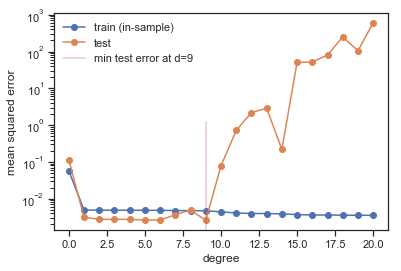

In [46]:
plt.plot(degrees, error_train, marker='o', label='train (in-sample)')
plt.plot(degrees, error_test, marker='o', label='test')
plt.axvline(bestd, 0,0.5, color='r', label="min test error at d=%d"%bestd, alpha=0.3)
plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='upper left')
plt.yscale("log")

![m:caption](images/complexity-error-plot.png)

# Part 3: Cross Validation

1. You should worry that a given split exposes us to the peculiarity of the data set that got randomly chosen for us. This naturally leads us to want to choose multiple such random splits and somehow average over this process to find the "best" validation minimizing polynomial degree or complexity $d$.
2. The multiple splits process also allows us to get an estimate of how consistent our prediction error is: in other words, just like in the hair example, it gives us a distribution.
3. Furthermore the validation set that we left out has two competing demands on it. The larger the set is, the better is our estimate of the out-of-sample error. So we'd like to hold out as much as possible. But the smaller the validation set is, the more data we have to train our model on. This allows us to have more smaller sets

In the figure below we create 4-folds from the training set part of our data set $\cal{D}$. By this we mean that we divide our set roughly into 4 equal parts. As illustrated below, this can be done in 4 different ways, or folds. In each fold we train a model on 3 of the parts. The model so trained is denoted as $g^-_{Fi}$, for example $g^-_{F3}$ . The minus sign in the superscript once again indicates that we are training on a reduced set. The $F3$ indicates that this model was trained on the third fold. Note that the model trained on each fold will be different!

For each fold, after training the model, we calculate the risk or error on the remaining one validation part. We then add the validation errors together from the different folds, and divide by the number of folds to calculate an average error. Note again that this average error is an average over different models $g^-_{Fi}$. We use this error as the validation error for $d=a$ in the validation process described earlier.

![m:caption](images/train-cv2.png)

Note that the number of folds is equal to the number of splits in the data. For example, if we have 5 splits, there will be 5 folds. To illustrate cross-validation consider below fits in $\cal{H}_0$ and $\cal{H}_1$ (means and straight lines) to a sine curve, with only 3 data points.

### The entire description of K-fold Cross-validation

We put thogether this scheme to calculate the error for a given polynomial degree $d$ with the method we used earlier to choose a model given the validation-set risk as a function of $d$:

1. create `n_folds` partitions of the training data. 
2. We then train on `n_folds -1` of these partitions, and test on the remaining partition. There are `n_folds` such combinations of partitions (or folds), and thus we obtain `n_fold` risks.
3. We average the error or risk of all such combinations to obtain, for each value of $d$, $R_{dCV}$.
4. We move on to the next value of $d$, and repeat 3
5. and then find the optimal value of d that minimizes risk $d=*$.
5. We finally use that value to make the final fit in $\cal{H}_*$ on the entire old training set.

![caption](images/train-cv3.png)

It can also be (empirically) shown that **cross-validation error is an unbiased estimate of the out of sample-error**.

Let us now do 4-fold cross-validation on our  data set. We increase the complexity from degree 0 to degree 20. In each case we take the old training set, split in 4 ways into 4 folds, train on 3 folds, and calculate the validation error on the remaining one. We then average the erros over the four folds to get a cross-validation error for that $d$. Then we did what we did before: find the hypothesis space $\cal{H}_*$ with the lowest cross-validation error, and refit it using the entire training set. We can then use the test set to estimate $E_{out}$.

We will use `KFold` from `scikit-learn`:

In [47]:
from sklearn.model_selection import KFold
n_folds=4
kfold = KFold(n_folds)
list(kfold.split(range(48)))

[(array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
         29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
         46, 47]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 24, 25, 26, 27, 28,
         29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
         46, 47]), array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
         46, 47]), array([24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35]), array([36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]))]

What is wrong with the above? Why must we do the below? Discuss before moving on!

In [48]:
kfold = KFold(n_folds, shuffle=True)
list(kfold.split(range(48)))

[(array([ 1,  3,  4,  6,  7,  8, 11, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25,
         27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
         46, 47]), array([ 0,  2,  5,  9, 10, 12, 18, 19, 20, 26, 31, 45])),
 (array([ 0,  1,  2,  3,  5,  6,  7,  9, 10, 11, 12, 13, 14, 16, 17, 18, 19,
         20, 21, 22, 24, 26, 27, 28, 31, 35, 36, 37, 39, 40, 41, 42, 43, 44,
         45, 47]), array([ 4,  8, 15, 23, 25, 29, 30, 32, 33, 34, 38, 46])),
 (array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 15, 16, 17, 18, 19,
         20, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 38, 39, 42, 43, 44,
         45, 46]), array([ 6, 13, 14, 21, 22, 27, 35, 36, 37, 40, 41, 47])),
 (array([ 0,  2,  4,  5,  6,  8,  9, 10, 12, 13, 14, 15, 18, 19, 20, 21, 22,
         23, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 45,
         46, 47]), array([ 1,  3,  7, 11, 16, 17, 24, 28, 39, 42, 43, 44]))]

### 4-fold CV on our data set

>***PRACTICE***: Carry out 4-Fold validation. For each fold, you will need to first create the polynomial features. for each degree polynomial, fit on the smaller training set and predict on the validation set. Store the MSEs, for each degree and each fold, in `train_errors` and `valid_errors`.

In [49]:
n_folds=4
degrees=range(21)
train_errors = np.zeros((21,4))
valid_errors = np.zeros((21,4))

In [ ]:
# your code here


We average the MSEs over the folds

In [ ]:
mean_train_errors = train_errors.mean(axis=1)
mean_valid_errors = valid_errors.mean(axis=1)
std_train_errors = train_errors.std(axis=1)
std_valid_errors = valid_errors.std(axis=1)

We find the degree that minimizes the `cross-validation` error, and just like before, refit the model on the entire training set

In [ ]:
mindeg = np.argmin(mean_valid_errors)
print(mindeg)
post_cv_train_dict, test_dict=make_features(xtrain, xtest, degrees)
#fit on whole training set now.
est = LinearRegression()
est.fit(post_cv_train_dict[mindeg], ytrain) # fit
pred = est.predict(test_dict[mindeg])
err = mean_squared_error(pred, ytest)
errtr=mean_squared_error(ytrain, est.predict(post_cv_train_dict[mindeg]))
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
plt.plot(degrees, mean_train_errors, marker='o', label='Train error', alpha=0.9)
plt.plot(degrees, mean_valid_errors, marker='o', label='CV error', alpha=0.9)

plt.fill_between(degrees, mean_valid_errors-std_valid_errors, mean_valid_errors+std_valid_errors, color=c1, alpha=0.2)

plt.plot([mindeg], [err], 'o',  label='test set error')

plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='upper right')
plt.yscale("log")

We see that the cross-validation error minimizes at a low degree, and then increases. Because we have so few data points the spread in fold errors increases as well.

# Part 4: Regularization

In [ ]:
def make_simple_plot():
    fig, axes=plt.subplots(figsize=(12,5), nrows=1, ncols=2);
    axes[0].set_ylabel("$y$")
    axes[0].set_xlabel("$x$")
    axes[1].set_xlabel("$x$")
    axes[1].set_yticklabels([])
    axes[0].set_ylim([-2,2])
    axes[1].set_ylim([-2,2])
    plt.tight_layout();
    return axes
def make_plot():
    fig, axes=plt.subplots(figsize=(20,8), nrows=1, ncols=2);
    axes[0].set_ylabel("$p_R$")
    axes[0].set_xlabel("$x$")
    axes[1].set_xlabel("$x$")
    axes[1].set_yticklabels([])
    axes[0].set_ylim([0,1])
    axes[1].set_ylim([0,1])
    axes[0].set_xlim([0,1])
    axes[1].set_xlim([0,1])
    plt.tight_layout();
    return axes

In [ ]:
def plot_functions(d, est, ax, df, alpha, xtest, Xtest, xtrain, ytrain):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.plot(df.x, df.f, color='k', label='f')
    ax.plot(xtrain, ytrain, 's', label="training", ms=5, alpha=0.3)
    ax.plot(xtest, ytest, 's', label="testing", ms=5, alpha=0.3)
    transx=np.arange(0,1.1,0.01)
    transX = PolynomialFeatures(d).fit_transform(transx.reshape(-1,1))
    ax.plot(transx, est.predict(transX),  '.', ms=7, alpha=0.8, label="alpha = %s" % str(alpha))
    ax.set_ylim((0, 1))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='lower right')
    
def plot_coefficients(est, ax, alpha):
    coef = est.coef_.ravel()
    ax.semilogy(np.abs(coef), marker='o', label="alpha = %s" % str(alpha))
    ax.set_ylim((1e-1, 1e15))
    ax.set_ylabel('abs(coefficient)')
    ax.set_xlabel('coefficients')
    ax.legend(loc='upper left')

Upto now we have focussed on finding the polynomial with the right degree of complecity $d=*$ given the data that we have.

When we **regularize** we smooth or restrict the choices of the kinds of 20th order polynomials that we allow in our fits. 

That is, if we want to fit with a 20th order polynomial, ok, lets fit with it, but lets reduce the size of, or limit the functions in $\cal{H}_{20}$ that we allow.


We do this by a **soft constraint** by setting:

$$\sum_{i=0}^j \beta_i^2 < C.$$

This setting is called the Ridge.

This ensures that the coefficients dont get too high, which makes sure we dont get wildly behaving polynomials with high coefficients. 

It turns out that we can do this by adding a term to the risk that we minimize on the training data for $\cal{H}_j$ (seeing why is beyond the scope here but google on lagrange multipliers and the dual problem):

$$\cal{R}(h_j) =  \sum_{y_i \in \cal{D}} (y_i - h_j(x_i))^2 +\alpha \sum_{i=0}^j \beta_i^2.$$

We use $\alpha$ instead of $\lambda$ since this is the terminology of the regularization parameter of sklearn 

### Regularization of our model with Cross-Validation

The addition of a penalty term to the risk or error causes us to choose a smaller subset of the entire set of complex $\cal{H}_{20}$ polynomials. This is shown in the diagram below where the balance between bias and variance occurs at some subset $S_*$ of the set of 20th order polynomials indexed by $\alpha_*$ (there is an error on the diagram, the 13 there should actually be a 20).

![m:caption](images/complexity-error-reg.png)

Lets see what some of the $\alpha$s do. The diagram below trains on the entire training set, for given values of $\alpha$, minimizing the penalty-term-added training error.

**Note that here we are doing the note so good thing of exhausting the test set for demonstration purposes**

In [ ]:
from sklearn.linear_model import Ridge
fig, rows = plt.subplots(6, 2, figsize=(12, 24))
d=20
alphas = [0.0, 1e-6, 1e-5, 1e-3, 0.01, 1]
train_dict, test_dict = make_features(xtrain, xtest, degrees)
Xtrain = train_dict[d]
Xtest = test_dict[d]
for i, alpha in enumerate(alphas):
    l,r=rows[i]
    est = Ridge(alpha=alpha)
    est.fit(Xtrain, ytrain)
    plot_functions(d, est, l, df, alpha, xtest, Xtest, xtrain, ytrain )
    plot_coefficients(est, r, alpha)

As you can see, as we increase $\alpha$ from 0 to 1, we start out overfitting, then doing well, and then, our fits, develop a mind of their own irrespective of data, as the penalty term dominates the risk.

### `GridSearchCV` meta-estimator

Lets use cross-validation to figure what this critical $\alpha_*$ is. To do this we use the concept of a *meta-estimator* from scikit-learn. As the API paper puts it:

>In scikit-learn, model selection is supported in two distinct meta-estimators, GridSearchCV and RandomizedSearchCV. They take as input an estimator (basic or composite), whose hyper-parameters must be optimized, and a set of hyperparameter settings to search through.

The concept of a meta-estimator allows us to wrap, for example, cross-validation, or methods that build and combine simpler models or schemes. For example:

    est = Ridge()
    parameters = {"alpha": [1e-8, 1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1.0]}
    gridclassifier=GridSearchCV(est, param_grid=parameters, cv=4, scoring="mean_squared_error")
    
The `GridSearchCV` replaces the manual iteration over thefolds using `KFolds` and the averaging we did previously, doing it all for us. It takes a parameter grid in the shape of a dictionary as input, and sets $\alpha$ to the appropriate parameter values one by one. It then trains the model, cross-validation fashion, and gets the error. Finally it compares the errors for the different $\alpha$'s, and picks the best choice model.

In [ ]:
from sklearn.model_selection import GridSearchCV
def cv_optimize_ridge(X, y, n_folds=4):
    est = Ridge()
    parameters = {"alpha": [1e-8, 1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1.0]}
    #the scoring parameter below is the default one in ridge, but you can use a different one
    #in the cross-validation phase if you want.
    gs = GridSearchCV(est, param_grid=parameters, cv=n_folds, scoring="neg_mean_squared_error", return_train_score=True)
    gs.fit(X, y)
    return gs

In [ ]:
fitmodel = cv_optimize_ridge(Xtrain, ytrain, n_folds=4)

In [ ]:
fitmodel.best_estimator_, fitmodel.best_params_, fitmodel.best_score_

In [ ]:
fitmodel.cv_results_

Our best model occurs for $\alpha=0.01$. We also output the mean cross-validation error at different $\alpha$ (with a negative sign, as scikit-learn likes to maximize negative error which is equivalent to minimizing error).

### Refitting on entire training set

We refit the estimator on old training set, and calculate and plot the test set error and the polynomial coefficients. Notice how many of these coefficients have been pushed to lower values or 0.


>**PRACTICE**: assign to variable est the classifier obtained by fitting the entire training set using the best $\alpha$ found above.

In [ ]:
#Store in est a new classifier fit on the entire training set with the best alpha
#your code here

In [ ]:
def plot_functions_onall(est, ax, df, alpha, xtrain, ytrain, Xtrain, xtest, ytest):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.plot(df.x, df.f, color='k', label='f')
    ax.plot(xtrain, ytrain, 's', alpha=0.4, label="train")
    ax.plot(xtest, ytest, 's', alpha=0.6, label="test")
    transx=np.arange(0,1.1,0.01)
    transX = PolynomialFeatures(20).fit_transform(transx.reshape(-1,1))
    ax.plot(transx, est.predict(transX), '.', alpha=0.6, label="alpha = %s" % str(alpha))
    #print est.predict(transX)
    ax.set_ylim((0, 1))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='lower right')

In [ ]:
fig, rows = plt.subplots(1, 2, figsize=(14, 6))
l,r=rows
plot_functions_onall(est, l, df, alphawechoose, xtrain, ytrain, Xtrain, xtest, ytest)
plot_coefficients(est, r, alphawechoose)

Discuss the results.